# SHACL Radar

Need To:

- [ ]  finish parquet pipeline



In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  ## remove pandas future warning
import pandas as pd
import pyoxigraph

## Load validation RDF graph

In [32]:
store = pyoxigraph.Store()  #  memory store  
mime_type = "application/n-triples"   # application/n-triples or application/n-quads if you are loading those

In [33]:
store.clear()
sources = ['./output/validation/immport.nt', './shapes/googleRequired_testing.nt']
for s in sources:
  store.load(s, mime_type, base_iri=None, to_graph=None)

In [34]:
sparql = """PREFIX shacl: <http://www.w3.org/ns/shacl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <https://schema.org/>

SELECT ?id ?name ?severity ?grname (STR(?refurl) AS ?str_refurl) (STR(?refresource) AS ?str_refresrouce) ?constraint ?path ?message (STR(?focus) AS ?focusURL) ?focusType ?value
WHERE {
  ?id rdf:type shacl:ValidationResult .
  ?id shacl:focusNode ?focus .
  ?id shacl:sourceShape ?ss .
  ?focus rdf:type ?focusType .
  ?id shacl:resultMessage ?message .
  ?id shacl:resultSeverity ?severity .
  ?id shacl:sourceConstraintComponent ?constraint .
  OPTIONAL {  ?ss shacl:name ?name . }
  OPTIONAL {  
    ?ss shacl:group ?group .
    ?group rdfs:label ?grname .
    ?group schema:url ?refurl .
    ?group rdfs:isDefinedBy ?refresource .
   }
  OPTIONAL { ?id shacl:resultPath ?path . }
  OPTIONAL { ?id shacl:value ?value . }
}
"""

r = store.query(sparql)
q1 = list(r)

In [35]:
# get the list of the variables from the query for ues in the dataframe
vars = r.variables
value_list = [variable.value for variable in vars]

In [36]:
# This map is necessary to get the values from the pyoxigraph.QuerySolutions 
def extract_value(cell):
    if isinstance(cell, (pyoxigraph.Literal, pyoxigraph.NamedNode, pyoxigraph.BlankNode)):
        return cell.value
    return cell

In [37]:
df = pd.DataFrame(q1, columns=value_list)

In [38]:
df = df.applymap(extract_value)

In [39]:
df

,id,name,severity,grname,str_refurl,str_refresrouce,constraint,path,message,focusURL,focusType,value
0,195c83d08eacbd30cc87815d3d51ad,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,F1,https://www.go-fair.org/fair-principles/f3-met...,https://w3id.org/fair/principles/terms/R1.1,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
1,195c83d08eacbd30cc87815d3d51ad,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,F1,https://www.go-fair.org/fair-principles/f3-met...,https://w3id.org/fair/principles/terms/R1.3,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
2,195c83d08eacbd30cc87815d3d51ad,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,F1,https://www.go-fair.org/fair-principles/f3-met...,https://w3id.org/fair/principles/terms/I1,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
3,195c83d08eacbd30cc87815d3d51ad,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,F1,https://www.go-fair.org/fair-principles/f3-met...,https://w3id.org/fair/principles/terms/F4,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
4,195c83d08eacbd30cc87815d3d51ad,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,F1,https://www.go-fair.org/fair-principles/f3-met...,https://w3id.org/fair/principles/terms/F2,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
...,...,...,...,...,...,...,...,...,...,...,...,...
579015,ffe83d9c43720f39df6c1fe7261e4bd0,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,R1.3,https://www.go-fair.org/fair-principles/fair-d...,https://w3id.org/fair/principles/terms/R1.2,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
579016,ffe83d9c43720f39df6c1fe7261e4bd0,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,R1.3,https://www.go-fair.org/fair-principles/fair-d...,https://w3id.org/fair/principles/terms/I3,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
579017,ffe83d9c43720f39df6c1fe7261e4bd0,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,R1.3,https://www.go-fair.org/fair-principles/fair-d...,https://w3id.org/fair/principles/terms/F1,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None
579018,ffe83d9c43720f39df6c1fe7261e4bd0,FAIR F1: URL check,http://www.w3.org/ns/shacl#Violation,R1.3,https://www.go-fair.org/fair-principles/fair-d...,https://w3id.org/fair/principles/terms/I2,http://www.w3.org/ns/shacl#MinCountConstraintC...,https://schema.org/url,Less than 2 values on [ rdf:type schema:Datase...,None,https://schema.org/Dataset,None


## plot from validation graph product


In [10]:
if 'grname' in df.columns:
  df['grname'] = df['grname'].astype(str)
  summary = df.groupby([df["grname"]]).count()
    # summary = df.groupby([df["message"]]).count()
  summary.reset_index(level=0, inplace=True)
  # summary['valid'] = summary['severity'].apply(lambda x: (countsdf["count"].sum()) - x)
else:
  pass

In [11]:
# Optional
# Save to CSV and analyze with tools like OpenRefine
# df.to_csv('report.csv', index=False)
# summary.to_csv('summary.csv', index=False)

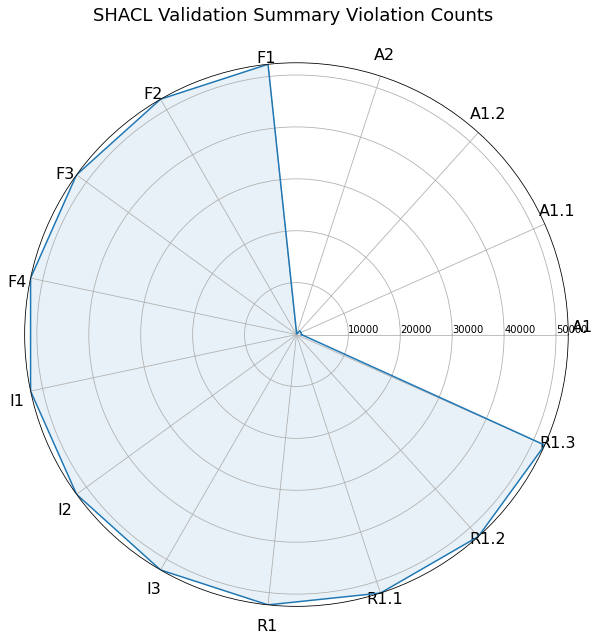

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Data
categories = summary['grname'].tolist()
values = summary['id'].tolist()

# Number of variables
N = len(categories)

# We are going to plot the first line of the data frame
# But we need to repeat the first value to close the circular graph
values += values[:1]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot data
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.1)

# Set the labels
plt.xticks(angles[:-1], categories,  fontsize=16)

# Adjust the position of labels to prevent overlapping with the plot
for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_horizontalalignment('center')
    label_angle = np.degrees(angle)
    if label_angle < 90 or label_angle > 270:
        label.set_verticalalignment('bottom')
    else:
        label.set_verticalalignment('top')
    label.set_rotation(label_angle - 90)  # Rotate labels

# Draw ylabels
ax.set_rlabel_position(0)
plt.ylim(0, summary["id"].max())

# Add a title
plt.title("SHACL Validation Summary Violation Counts \n",  fontsize=18)

# Show the graph
plt.show()

## Optional:  Load and plot parquet product

In [196]:
# parquet files (do not use this yet), need to flesh this out 
# df = pd.read_parquet('./output/validation/immport.parquet')
df = pd.read_parquet('./output/validation/veupath.parquet')

In [197]:
if 'grname' in df.columns:
  df['grname'] = df['grname'].astype(str)
  summary = df.groupby([df["grname"]]).count()
    # summary = df.groupby([df["message"]]).count()
  summary.reset_index(level=0, inplace=True)
  # summary['valid'] = summary['severity'].apply(lambda x: (countsdf["count"].sum()) - x)
else:
  pass

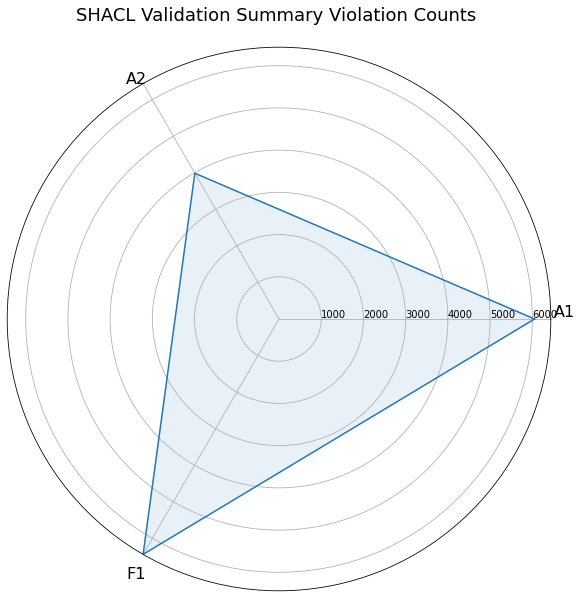

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Data
categories = summary['grname'].tolist()
values = summary['id'].tolist()

# Number of variables
N = len(categories)

# We are going to plot the first line of the data frame
# But we need to repeat the first value to close the circular graph
values += values[:1]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot data
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.1)

# Set the labels
plt.xticks(angles[:-1], categories,  fontsize=16)

# Adjust the position of labels to prevent overlapping with the plot
for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_horizontalalignment('center')
    label_angle = np.degrees(angle)
    if label_angle < 90 or label_angle > 270:
        label.set_verticalalignment('bottom')
    else:
        label.set_verticalalignment('top')
    label.set_rotation(label_angle - 90)  # Rotate labels

# Draw ylabels
ax.set_rlabel_position(0)
plt.ylim(0, summary["id"].max())

# Add a title
plt.title("SHACL Validation Summary Violation Counts \n",  fontsize=18)

# Show the graph
plt.show()

## Notes

* need to have all 15 FAIR principles in the radar graph,  set to 0 if not in the report